# Comparison of Statistical and Consistent Bayesian Inversion

We define a problem where the observed density corresponds to a likelihood function from classical Bayesian inversion

Copyright 2018 Michael Pilosov


In [1]:
import numpy as np
import scipy.stats as sstats
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams['font.size'] = 24

In [3]:
import cbayes.sample as samp
import cbayes.distributions as dist
import cbayes.solve as solve

In [60]:
p = 1
def QoI_fun(lam):
    return np.power(lam, p).reshape(-1, 1)

## Consistent Bayes

In [61]:
N = int(5E4)
input_dim = 1
output_dim = input_dim
s_set = samp.sample_set(size=(N, input_dim))
for i in range(input_dim):# define prior distribution
    s_set.set_dist('uni', {'loc':-1, 'scale':2}, 0) # uniform
#     s_set.set_dist('norm', {'loc':0, 'scale':0.5}, 0) # normal distribution 
s_set.generate_samples()
p_set = samp.map_samples_and_create_problem(s_set, QoI_fun)

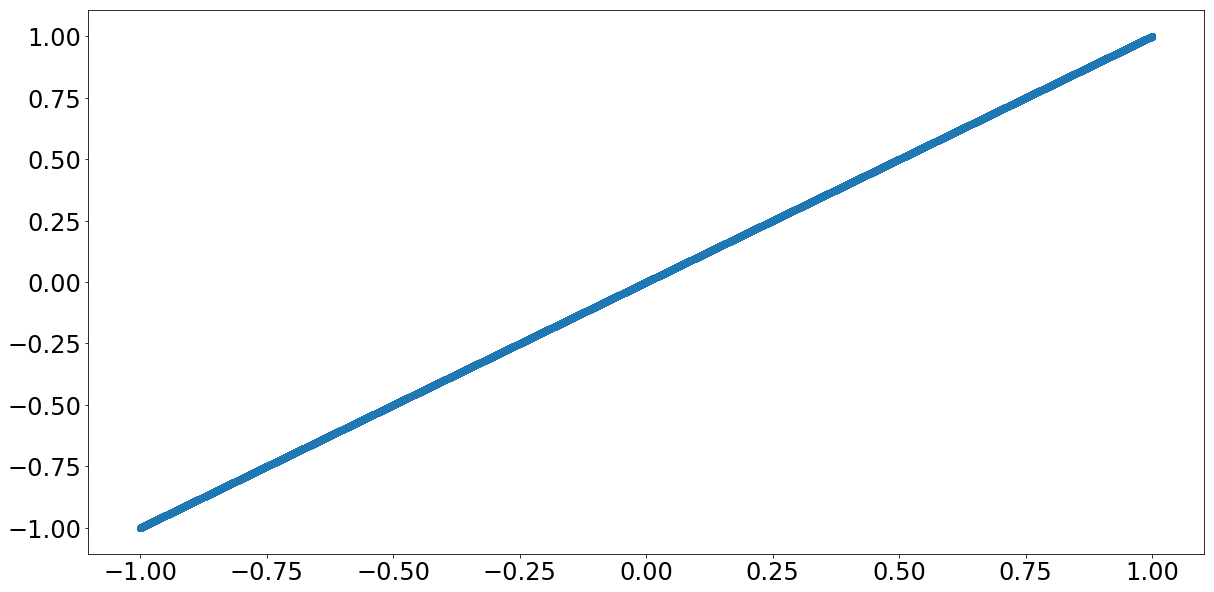

In [62]:
plt.scatter(p_set.input.samples[:], p_set.output.samples[:])
plt.show()

In [63]:
sd = 0.1
lo = 0.25
p_set.set_observed_dist('norm', dim=0, kwds={'loc':lo, 'scale': sd})

In [64]:
# p_set.compute_pushforward_dist(method='sk',kwds={'kernel': 'gaussian', 'bandwidth':0.01}) # custom options
p_set.compute_pushforward_dist(method='sc')

In [65]:
# CREATE SHORT-VERSION FUNCTION HANDLES (for convenience)
pf = p_set.pushforward_dist
pr = p_set.prior_dist
ob = p_set.observed_dist

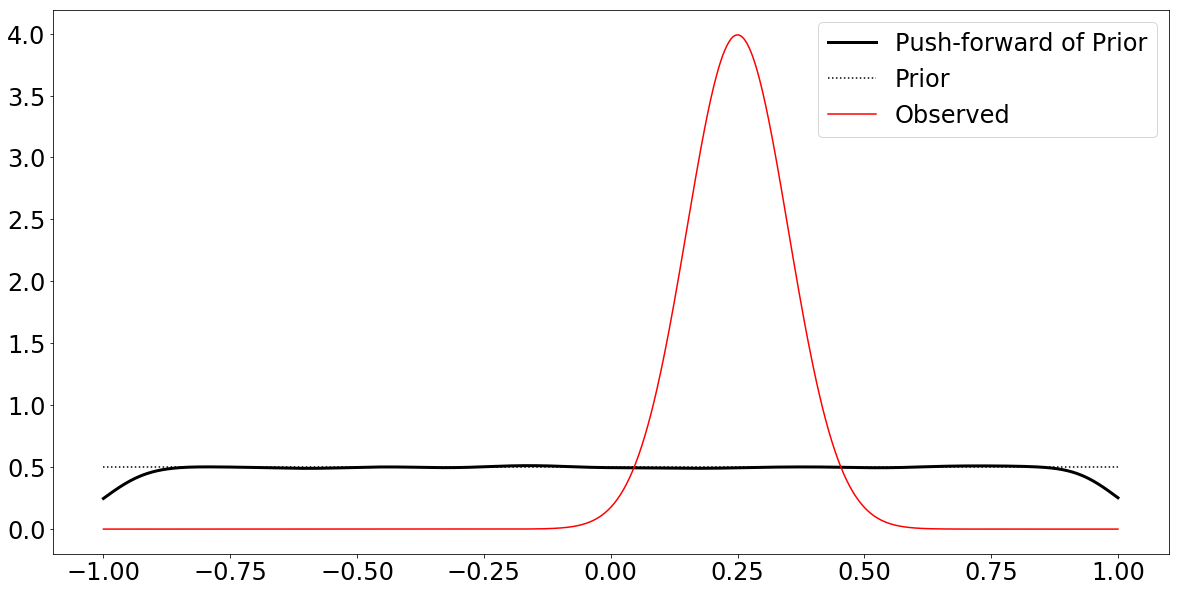

In [66]:
x = np.linspace(-1.0,1.0,1000)
plt.plot(x,pf.pdf(x), label='Push-forward of Prior', c='k',lw=3)
plt.plot(x,pr.pdf(x), label='Prior', c = 'k', ls=':')
plt.plot(x,ob.pdf(x), label='Observed', c='r')
plt.legend()
plt.savefig('p%d_first_fig.png'%(p))
plt.show()

In [67]:
# Solve CBayes 
p_set.set_ratio()
solve.problem(p_set)

## Statistical Bayes

In [68]:
L = dist.parametric_dist(output_dim) # Define likelihood
for i in range(output_dim):
    L.set_dist(i, 'norm',{'loc':lo, 'scale':sd })


In [69]:
likelihood = L.pdf(p_set.output.samples)
prior = p_set.input.dist.pdf(p_set.input.samples)

In [70]:
# check what the integrating constant should be.
import scipy.integrate as integrate
def statBayesPost(x):
    y = ob.pdf(QoI_fun(x))
    return y

intConst=integrate.quad(statBayesPost,-1,1)
print(intConst)

(0.9999999999999681, 8.136616229407676e-09)


In [71]:
indS = solve.perform_accept_reject(p_set.output.samples, likelihood)
indC = solve.perform_accept_reject(p_set.output.samples, p_set.ratio,seed=25)
print("ACCEPTED:", "S:", len(indS), "| B:", len(indC), " OF", N)

ACCEPTED: S: 6174 | B: 6202  OF 50000


In [72]:
# SMOOTH POSTERIORS FOR PLOTTING
cb_ps_den = dist.gkde(p_set.input.samples[indC])
sb_ps_den = dist.gkde(p_set.input.samples[indS])
# SMOOTH PUSH-FORWARDS OF POSTERIORS FOR PLOTTING
cb_pf_den = dist.gkde(p_set.output.samples[indC])
sb_pf_den = dist.gkde(p_set.output.samples[indS])

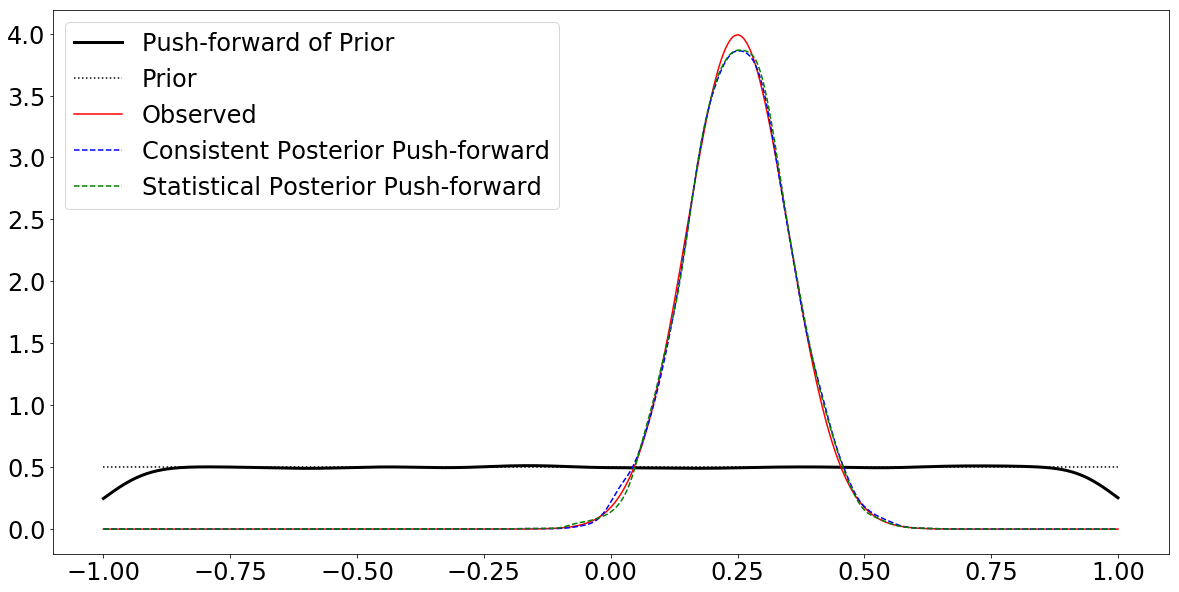

In [73]:
plt.plot(x,pf.pdf(x), label='Push-forward of Prior', c='k',lw=3)
plt.plot(x,pr.pdf(x), label='Prior', c = 'k', ls=':')
plt.plot(x,ob.pdf(x), label='Observed', c='r')

plt.plot(x, cb_pf_den.pdf(x),  c='b', ls='--', label='Consistent Posterior Push-forward')
plt.plot(x, sb_pf_den.pdf(x),  c='g', ls='--', label='Statistical Posterior Push-forward')
# plt.ylim([0,6])
plt.legend()
plt.savefig('comparison%d.png'%p)
plt.show()